# Fast Spectrometry Time Dependence - Stacked Graph

This notebook plots all fast spectrometry signals on a single stacked graph with:
- Each signal having a different color
- The "Whole" signal shown in bold black

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from golem_data_loader import GolemDataLoader, SpectroscopyLine

# Increase global font sizes for readability
plt.rcParams.update(
    {
        "font.size": 16,  # base font size
        "axes.labelsize": 24,  # x/y labels
        "axes.titlesize": 24,  # subplot titles
        "xtick.labelsize": 20,  # x tick labels
        "ytick.labelsize": 20,  # y tick labels
        "legend.fontsize": 18,  # legends
        "figure.titlesize": 22,  # suptitle
    }
)

In [34]:
shotno = 50709

In [35]:
# Initialize the GOLEM data loader
loader = GolemDataLoader(shotno)

# Load fast spectrometry data
spectrometry_data = loader.load_fast_spectrometry()

# Convert to the original data format
data = {name: spec_data.raw_dataframe for name, spec_data in spectrometry_data.items()}

# Print loaded data info
for label, spec_data in spectrometry_data.items():
    print(f"{label}: loaded {len(spec_data.time)} rows")

2026-01-20 16:06:45,916 - golem_data_loader.golem_data_loader - INFO - Successfully loaded plasma start time from http://golem.fjfi.cvut.cz/shots/50709/Diagnostics/PlasmaDetection/Results/t_plasma_start
2026-01-20 16:06:45,969 - golem_data_loader.golem_data_loader - INFO - Successfully loaded plasma end time from http://golem.fjfi.cvut.cz/shots/50709/Diagnostics/PlasmaDetection/Results/t_plasma_end
2026-01-20 16:06:45,969 - golem_data_loader.golem_data_loader - INFO - Loaded plasma timing: 1.53 - 13.10 ms
2026-01-20 16:06:47,680 - golem_data_loader.golem_data_loader - INFO - Successfully loaded Hα 656.5nm spectrometry from http://golem.fjfi.cvut.cz/shots/50709/Diagnostics/FastSpectrometry/DAS_raw_data_dir/ch8.csv
2026-01-20 16:06:47,707 - golem_data_loader.golem_data_loader - INFO - Hα 656.5nm: loaded 19999 rows, columns = ['    0', '0.001']
2026-01-20 16:06:50,899 - golem_data_loader.golem_data_loader - INFO - Successfully loaded Cl II 479.5nm spectrometry from http://golem.fjfi.cvut.

Hα 656.5nm: loaded 19999 rows
Cl II 479.5nm: loaded 19999 rows
He I 588nm: loaded 19999 rows
Whole: loaded 19999 rows
C II 514.5nm: loaded 3999 rows
N II 568.6nm: loaded 3999 rows
O I 777nm: loaded 3999 rows
He I 447.1nm: loaded 3999 rows


In [36]:
transmissions = {
    "Hα 656.5nm": 0.399344466183746,
    "Hb 486nm": 0.3092707494634666,
    "Hg 434nm": 0.32171625016564587,
    "He I 588nm": 0.30580924514216323,
    "C II 514.5nm": 0.4422102032614363,
    "N II 568.6nm": 0.42901271735930263,
    "O I 777nm": 0.28658030783004285,
    "He I 447.1nm": 0.7919005066582551,
    "Cl II 479.5nm": 0.29519876882526447,
    "Whole": 0.1
}

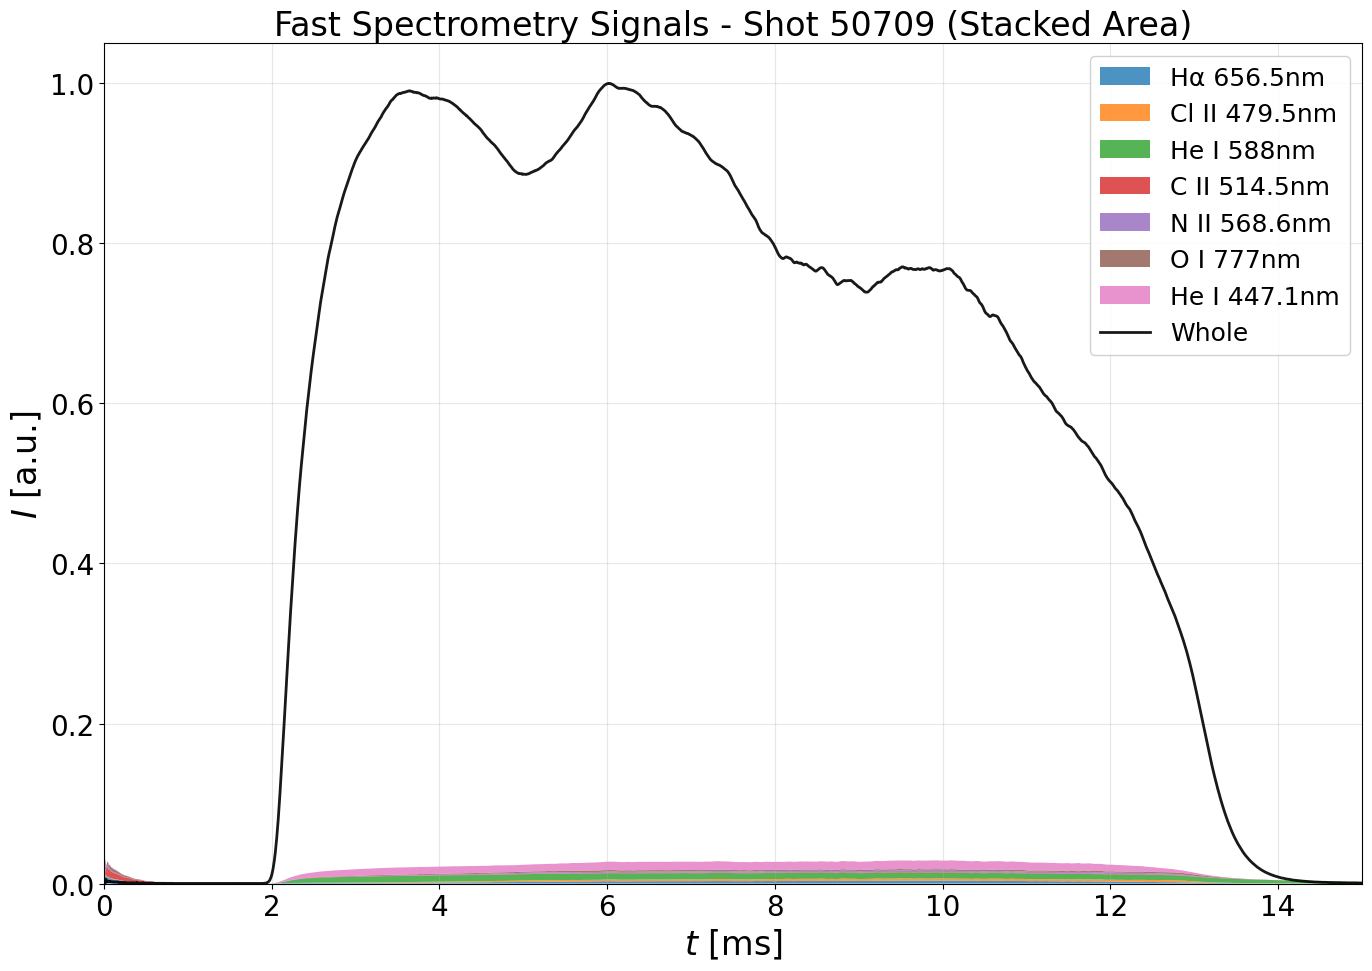

In [56]:
# Create a single figure with stacked area plot
fig, ax = plt.subplots(figsize=(14, 10))

# Define colors for all signals
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive']

# Find the signal with highest sampling rate to use as common time grid
max_samples = 0
common_time: np.ndarray | None = None
for label, df in data.items():
    if len(df) > max_samples:
        max_samples = len(df)
        common_time = df.iloc[:, 0].values

# Interpolate all signals to the common time grid
data_interpolated: dict[str, np.ndarray] = {}
if common_time is None:
    raise
for label, df in data.items():
    t_orig: np.ndarray = df.iloc[:, 0].values
    u_orig: np.ndarray = df.iloc[:, 1].values
    
    # Interpolate to common time grid
    u_interp: np.ndarray = np.interp(common_time, t_orig, u_orig)
    data_interpolated[label] = u_interp

# Map spectral lines to their wavelengths for DET100 responsivity correction
line_wavelengths = {
    "Hα 656.5nm": 656.5,
    "Hb 486nm": 486.0,
    "Hg 434nm": 434.0,
    "He I 588nm": 588.0,
    "C II 514.5nm": 514.5,
    "N II 568.6nm": 568.6,
    "O I 777nm": 777.0,
    "He I 447.1nm": 447.1,
    "Cl II 479.5nm": 479.5,
    "Whole": 500.0  # average wavelength for broadband
}

# Apply DET100 responsivity correction to each signal
data_resp_corrected: dict[str, np.ndarray] = {}
for label, u in data_interpolated.items():
    # Get the wavelength for this spectral line
    wavelength = line_wavelengths[label]
    # Interpolate DET100 responsivity at this wavelength
    responsivity = np.interp(wavelength, 
                            det100_data['Wavelength (nm)'], 
                            det100_data['Responsivity (A/W)'])
    # Divide by responsivity to correct for detector response
    data_resp_corrected[label] = u / responsivity

# Apply transmission correction to each signal
data_corrected: dict[str, np.ndarray] = {}
for label, u in data_resp_corrected.items():
        # Divide by transmission to correct for optical losses
        data_corrected[label] = u / transmissions[label]

# Normalize all signals to 0-1 range based on global maximum
max_value = max(np.max(u) for u in data_corrected.values())
for label in data_corrected:
    data_corrected[label] = data_corrected[label] / max_value

# Separate "Whole" from other signals
signals_to_stack = [(label, u) for label, u in data_corrected.items() if label != "Whole"]
whole_signal = data_corrected.get("Whole")

# Create stacked area plot with all signals (except Whole)
if signals_to_stack:
    signal_arrays: list[np.ndarray] = []
    signal_labels: list[str] = []
    for label, u in signals_to_stack:
        signal_arrays.append(u)
        signal_labels.append(label)
    
    # Create stacked area plot
    ax.stackplot(common_time * 1e3, *signal_arrays, labels=signal_labels, colors=colors[:len(signal_arrays)], alpha=0.8)

# Plot "Whole" signal as a bold black line on top
if whole_signal is not None:
    ax.plot(common_time * 1e3, whole_signal, label="Whole", color='black', linewidth=2, alpha=0.9, zorder=10)

# Styling
ax.set_xlabel(r"$t$ [ms]")
ax.set_ylabel(r"$I$ [a.u.]")
ax.set_xlim(0, 15)
ax.set_ylim(0, None)
ax.set_title(f"Fast Spectrometry Signals - Shot {shotno} (Stacked Area)")
ax.grid(True, alpha=0.3)
ax.legend(loc='best', framealpha=0.9)

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()


In [38]:
# Load mini spectrometer H5 data
h5_data = loader.load_minispectrometer_h5()
Spectra = h5_data.spectra
Wavelengths = h5_data.wavelengths

print(f"Loaded spectra with shape: {Spectra.shape}")
print(f"Wavelength range: {Wavelengths[0]:.2f} - {Wavelengths[-1]:.2f} nm")

# Load quantum efficiency data
qe_data = pd.read_csv('data/quantum_efficiency.csv')
print(f"\nLoaded quantum efficiency data with shape: {qe_data.shape}")

# Load DET100 silicon photodiode responsivity data
det100_data = pd.read_csv('data/DET100_responsivity.csv')
print(f"Loaded DET100 responsivity data with shape: {det100_data.shape}")

2026-01-20 16:06:55,369 - golem_data_loader.golem_data_loader - INFO - Downloading H5 file to /var/folders/8r/sqs2hl_s6f3fmch121kzp_yh0000gn/T/tmpb3i3k_lw.h5
2026-01-20 16:06:55,784 - golem_data_loader.golem_data_loader - INFO - Successfully loaded mini-spectrometer H5 file from http://golem.fjfi.cvut.cz/shots/50709/Diagnostics/MiniSpectrometer/DAS_raw_data_dir/IRVISUV_0.h5
2026-01-20 16:06:55,786 - golem_data_loader.golem_data_loader - INFO - Successfully downloaded H5 file (102864 bytes)
2026-01-20 16:06:55,812 - golem_data_loader.golem_data_loader - INFO - Loaded spectra: shape=(20, 2048), wavelengths: shape=(2047,)
2026-01-20 16:06:55,814 - golem_data_loader.golem_data_loader - WARNING - Mini-spectrometer data has mismatched lengths: spectra=2048, wavelengths=2047; trimming to 2047 columns
2026-01-20 16:06:55,819 - golem_data_loader.golem_data_loader - INFO - Applied ILX511B spectral sensitivity compensation to mini-spectrometer spectra
2026-01-20 16:06:55,820 - golem_data_loader.g

Loaded spectra with shape: (20, 2047)
Wavelength range: 188.11 - 1108.53 nm

Loaded quantum efficiency data with shape: (10656, 10)
Loaded DET100 responsivity data with shape: (44, 2)


In [39]:
def compute_mini_spectrometer_intensity(Spectra, Wavelengths, peak_wavelength, fwhm, qe_data=None, qe_channel=None, det100_data=None):
    """
    Compute time-dependent intensity from mini-spectrometer data by integrating over a spectral line.
    
    Parameters:
    -----------
    Spectra : array-like
        2D array of spectra (time x wavelength)
    Wavelengths : array-like
        Wavelength array corresponding to spectral dimension
    peak_wavelength : float
        Central wavelength of the spectral line (nm)
    fwhm : float
        Full width at half maximum for integration window (nm)
    qe_data : DataFrame, optional
        Quantum efficiency data with 'Wavelength (nm)' column
    qe_channel : str, optional
        Column name in qe_data for the specific QE channel to apply
    det100_data : DataFrame, optional
        DET100 responsivity data
        
    Returns:
    --------
    tuple : (time_array, intensity_array)
        Time array in ms and corresponding integrated intensity values
    """
    # Select wavelengths within +/- (FWHM/2) around the peak wavelength
    wavelength_mask = (Wavelengths >= peak_wavelength - fwhm/2) & (Wavelengths <= peak_wavelength + fwhm/2)
    wavelength_indexes = np.where(wavelength_mask)[0]
    
    # Create time array and integrate intensity for each spectrum
    mini_spectrometer_t = np.arange(2, 2*len(Spectra)+2, 2)
    mini_spectrometer_intensity = []
    
    for i in range(len(Spectra)):
        # Extract intensity values at the selected wavelength indexes
        spectrum_slice = Spectra[i][wavelength_indexes]
        
        # Apply DET100 responsivity if available
        if det100_data is not None:
            # Interpolate DET100 responsivity to match the spectrum wavelengths
            det100_resp = np.interp(Wavelengths[wavelength_indexes], 
                                   det100_data['Wavelength (nm)'], 
                                   det100_data['Responsivity (A/W)'],
                                   left=0, right=0)
            # Apply responsivity to the spectrum
            spectrum_slice = spectrum_slice * det100_resp
        
        # Apply quantum efficiency weighting if available
        if qe_channel is not None and qe_data is not None and qe_channel in qe_data.columns:
            # Interpolate QE values to match the spectrum wavelengths
            qe_weights = np.interp(Wavelengths[wavelength_indexes], 
                                  qe_data['Wavelength (nm)'], 
                                  qe_data[qe_channel],
                                  left=0, right=0)  # Use 0 for out-of-range values
            # Apply weights to the spectrum
            spectrum_slice = spectrum_slice * qe_weights
        
        # Integrate using trapezoidal rule
        total_intensity = np.trapezoid(spectrum_slice, Wavelengths[wavelength_indexes])
        mini_spectrometer_intensity.append(total_intensity)
    
    return mini_spectrometer_t, np.array(mini_spectrometer_intensity)

In [52]:
# Define spectral line parameters with quantum efficiency channels
mini_peaks = [
    {"name": "Hα 656.5nm", "wavelength": 656.0, "fwhm": 10, "qe_channel": "Ha656"},
    {"name": "Cl II 479.5nm", "wavelength": 480.0, "fwhm": 10, "qe_channel": "ClII479"},
    {"name": "He I 588nm", "wavelength": 590.0, "fwhm": 10, "qe_channel": "HeI588"},
    {"name": "C II 514.5nm", "wavelength": 515.0, "fwhm": 10, "qe_channel": "CII515"},
    {"name": "N II 568.6nm", "wavelength": 570.0, "fwhm": 10, "qe_channel": "NII569"},
    {"name": "O I 777nm", "wavelength": 780.0, "fwhm": 10, "qe_channel": "O777PP"},
    {"name": "He I 447.1nm", "wavelength": 450.0, "fwhm": 10, "qe_channel": "HeI447"},
    {"name": "Whole", "wavelength": 500.0, "fwhm": 1000, "qe_channel": None},
]

# Compute mini spectrometer intensities for each spectral line
mini_data = {}
for peak in mini_peaks:
    mini_t, mini_intensity = compute_mini_spectrometer_intensity(
        Spectra, Wavelengths, 
        peak["wavelength"], 
        peak["fwhm"], 
    )
    mini_data[peak["name"]] = (mini_t, mini_intensity)
    print(f"{peak['name']}: computed {len(mini_intensity)} samples")

Hα 656.5nm: computed 20 samples
Cl II 479.5nm: computed 20 samples
He I 588nm: computed 20 samples
C II 514.5nm: computed 20 samples
N II 568.6nm: computed 20 samples
O I 777nm: computed 20 samples
He I 447.1nm: computed 20 samples
Whole: computed 20 samples


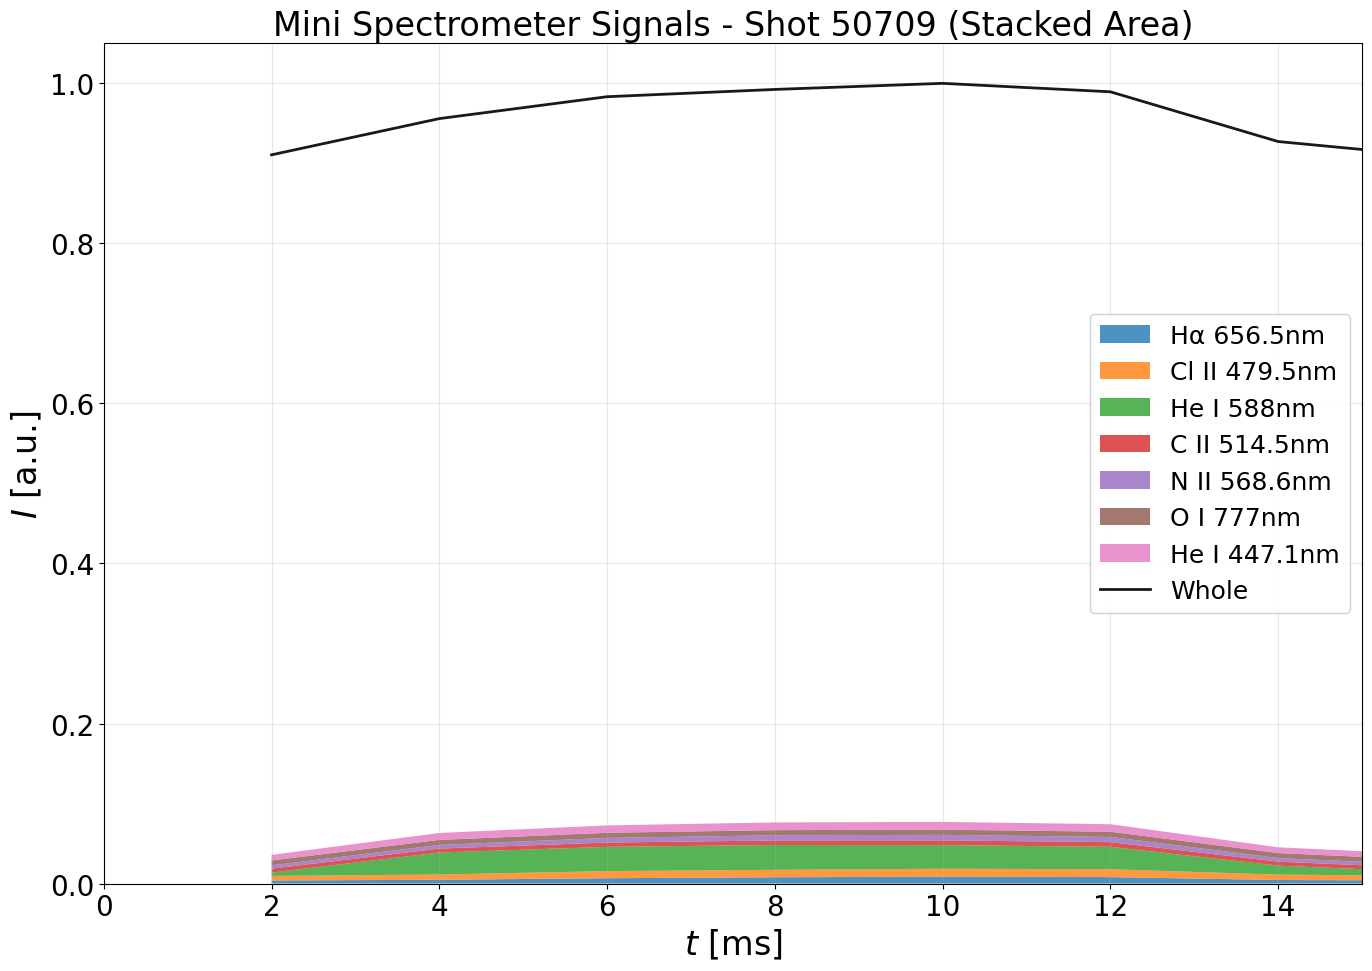

In [53]:
# Create stacked area plot for mini spectrometer data
fig, ax = plt.subplots(figsize=(14, 10))

# Define colors for all signals
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive']

# Use mini spectrometer time as common time grid
common_time_mini = mini_data[list(mini_data.keys())[0]][0] / 1e3  # convert ms to s

# Interpolate all mini signals to the common time grid and store
mini_data_interpolated = {}
for label, (t_mini, u_mini) in mini_data.items():
    # Convert time to seconds for consistency
    t_mini_s = t_mini / 1e3
    # Interpolate to common time grid
    u_interp = np.interp(common_time_mini, t_mini_s, u_mini)
    mini_data_interpolated[label] = u_interp

# Normalize all signals to 0-1 range based on global maximum
max_value_mini = max(np.max(u) for u in mini_data_interpolated.values())
for label in mini_data_interpolated:
    mini_data_interpolated[label] = mini_data_interpolated[label] / max_value_mini

# Separate "Whole" from other signals
signals_to_stack = [(label, u) for label, u in mini_data_interpolated.items() if label != "Whole"]
whole_signal = mini_data_interpolated.get("Whole")
# Create stacked area plot with all signals (except Whole)
if signals_to_stack:
    signal_arrays = []
    signal_labels = []
    for label, u in signals_to_stack:
        signal_arrays.append(u)
        signal_labels.append(label)
    
    # Create stacked area plot
    ax.stackplot(common_time_mini * 1e3, *signal_arrays, labels=signal_labels, colors=colors[:len(signal_arrays)], alpha=0.8)

# Plot "Whole" signal as a bold black line on top
if whole_signal is not None:
    ax.plot(common_time_mini * 1e3, whole_signal, label="Whole", color='black', linewidth=2, alpha=0.9, zorder=10)

# Styling
ax.set_xlabel(r"$t$ [ms]")
ax.set_ylabel(r"$I$ [a.u.]")
ax.set_xlim(0, 15)
ax.set_ylim(0, None)
ax.set_title(f"Mini Spectrometer Signals - Shot {shotno} (Stacked Area)")
ax.grid(True, alpha=0.3)
ax.legend(loc='best', framealpha=0.9)

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()
